# 📄 Project Euler 151 — Paper sheets of standard sizes: an expected-value problem

## Nome: Morsinaldo de Azevedo Medeiros

A printing shop runs 16 batches (jobs) every week and each batch requires a sheet of special colour-proofing paper of size A5.  

Every Monday morning, the supervisor opens a new envelope, containing a large sheet of the special paper with size A1.  

The supervisor proceeds to cut it in half, thus getting two sheets of size A2. Then one of the sheets is cut in half to get two sheets of size A3 and so on until an A5-size sheet is obtained, which is needed for the first batch of the week.  

All the unused sheets are placed back in the envelope.  

At the beginning of each subsequent batch, the supervisor takes from the envelope one sheet of paper at random. If it is of size A5, then it is used. If it is larger, then the 'cut-in-half' procedure is repeated until an A5-size sheet is obtained, and any remaining sheets are always placed back in the envelope.  

Excluding the first and last batch of the week, find the expected number of times (during each week) that the supervisor finds a single sheet of paper in the envelope.  

Give your answer rounded to six decimal places using the format x.xxxxxx.

## 🧭 Modelagem

- Representamos o estado do envelope como `(a2, a3, a4, a5)`, contagens de A2..A5.  
- Após o 1º lote (A1 cortada), o estado inicial efetivo para o 2º lote é **(1,1,1,1)**.  
- Em cada lote aplicamos:
  1) **Sorteio proporcional**: escolhe-se um tamanho com probabilidade `contagem / total`.
  2) **Atualização**:
     - Se escolher **A5**: `a5 -= 1` (foi consumida).
     - Se escolher **Ai** com *i<5*: remove 1 em `Ai` e adiciona **+1** em cada tamanho acima até A5 (A(i+1), A(i+2), ..., A5).

- A esperança procurada é  
  \[
  \mathbb{E}[\#\text{vezes envelope com 1 folha}] \;=\; \sum_{t=2}^{15}\Pr\{a_2+a_3+a_4+a_5 = 1 \text{ no início do lote } t\}.
  \]
  Para isso, propagamos a **distribuição de probabilidade** sobre os estados ao longo dos lotes.

In [ ]:
# Importações
from fractions import Fraction
from collections import Counter, defaultdict

## 🧩 Estado inicial

Após o 1º lote (A1 cortada até A5), o envelope contém uma de cada: A2, A3, A4, A5.

In [3]:
start = (1, 1, 1, 1)  # estado no início do 2º lote

## 🔁 Transições de um lote

Dado `state = (a2,a3,a4,a5)` com total `T=a2+a3+a4+a5`:
- Probabilidade de escolher A2 é `a2/T`, etc.
- Atualizações:
  - **A2** → (a2-1, a3+1, a4+1, a5+1)
  - **A3** → (a2,   a3-1, a4+1, a5+1)
  - **A4** → (a2,   a3,   a4-1, a5+1)
  - **A5** → (a2,   a3,   a4,   a5-1)

In [4]:
def next_states(state):
    """Retorna {estado': probabilidade} após processar 1 lote a partir de 'state'."""
    a2, a3, a4, a5 = state
    total = a2 + a3 + a4 + a5
    if total == 0:
        return {}  # semana encerrada; sem transições
    
    out = defaultdict(Fraction)
    # Escolha de A2
    if a2:
        p = Fraction(a2, total)
        out[(a2-1, a3+1, a4+1, a5+1)] += p
    # Escolha de A3
    if a3:
        p = Fraction(a3, total)
        out[(a2,   a3-1, a4+1, a5+1)] += p
    # Escolha de A4
    if a4:
        p = Fraction(a4, total)
        out[(a2,   a3,   a4-1, a5+1)] += p
    # Escolha de A5 (consome)
    if a5:
        p = Fraction(a5, total)
        out[(a2,   a3,   a4,   a5-1)] += p
    
    return out

## ▶️ Propagação da distribuição

- `dist` armazena a distribuição no início de cada lote.  
- No início do lote `t`, somamos `dist[state]` para todos os `state` com `a2+a3+a4+a5 == 1` quando `t ∈ {2,…,15}`.  
- Em seguida, usamos `next_states` para obter a distribuição do início do lote seguinte.

In [9]:
dist = Counter({start: Fraction(1, 1)})

probs_one_sheet = []      # P(exatamente 1 folha) no INÍCIO de cada lote 2..15
batches_index = []        # índices dos lotes correspondentes (2..15)
expected = Fraction(0, 1)

for batch in range(2, 17):  # 2..16
    # probabilidade de "1 folha" no INÍCIO deste lote
    if batch <= 15:
        p_one = sum(
            p for (a2, a3, a4, a5), p in dist.items()
            if (a2 + a3 + a4 + a5) == 1
        )
        probs_one_sheet.append(p_one)
        batches_index.append(batch)
        expected += p_one
    
    # transição para o próximo início de lote
    next_dist = Counter()
    for s, p in dist.items():
        for ns, w in next_states(s).items():
            next_dist[ns] += p * w
    dist = next_dist

## ✅ Resultado

A esperança calculada abaixo é exata (fração).  
Em seguida, exibimos também o valor em decimal com seis casas.

In [10]:
print("Fração reduzida:", expected)
print("Valor em decimal:", round(float(expected), 6))

Fração reduzida: 12138569781349/26138246400000
Valor em decimal: 0.464399


![Alt text](./figures/project_euler_151_answered.png "Project Euler 151 Answered")

## 🧾 Visualização tabular

Mostramos o par (lote, probabilidade) e a soma parcial acumulada.

In [11]:
acc = Fraction(0, 1)
for b, p in zip(batches_index, probs_one_sheet):
    acc += p
    print(f"Lote {b:2d}: P(1 folha) = {float(p):.6f}   |  soma acumulada = {float(acc):.6f}")

Lote  2: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  3: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  4: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  5: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  6: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  7: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  8: P(1 folha) = 0.000000   |  soma acumulada = 0.000000
Lote  9: P(1 folha) = 0.060499   |  soma acumulada = 0.060499
Lote 10: P(1 folha) = 0.000000   |  soma acumulada = 0.060499
Lote 11: P(1 folha) = 0.000000   |  soma acumulada = 0.060499
Lote 12: P(1 folha) = 0.000000   |  soma acumulada = 0.060499
Lote 13: P(1 folha) = 0.104859   |  soma acumulada = 0.165358
Lote 14: P(1 folha) = 0.000000   |  soma acumulada = 0.165358
Lote 15: P(1 folha) = 0.299041   |  soma acumulada = 0.464399


## 📊 Gráfico (probabilidade × lote)

Gráfico simples da probabilidade de “1 folha” em função do número do lote (2..15).

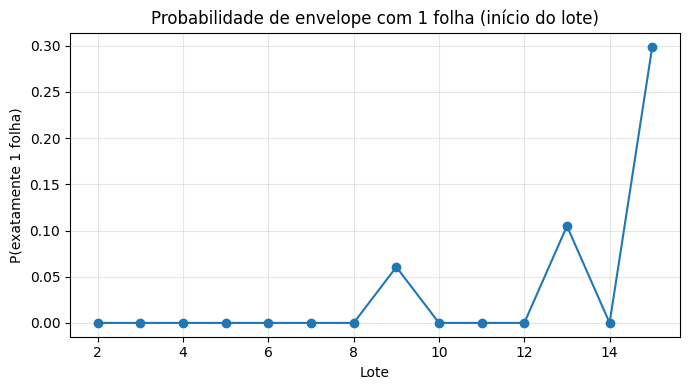

In [12]:
import matplotlib.pyplot as plt

xs = batches_index
ys = [float(p) for p in probs_one_sheet]

plt.figure(figsize=(7,4))
plt.plot(xs, ys, marker="o")
plt.title("Probabilidade de envelope com 1 folha (início do lote)")
plt.xlabel("Lote")
plt.ylabel("P(exatamente 1 folha)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()